# Машинное обучение в бизнесе

## Урок3. Связь бизнес-показателей и DS-метрик

__Домашнее задание__
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).

p.s. В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).<br>
Допустим, у нас две модели:
- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Ссылки
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## <center> Практическое задание </center>

### Описание датасета

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:
- __age__ - Возраст (дни)
- __height__ - Рост
- __weight__ - Вес
- __gender__ - Пол

Результаты измерения:
- __ap_hi__ - Артериальное давление верхнее
- __ap_lo__ -Артериальное давление верхнее и нижнее
- __cholesterol__ - Холестерин
- __gluc__ - Глюкоза

Субъективные признаки:
- __smoke__ - Курение
- __alco__ - Употребление Алкоголя
- __active__ - Физическая активность

Возраст дан в днях.<br>
Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы.<br>
Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.


Таргет - __cardio__ наличие сердечно-сосудистых заболеваний (ССЗ)
### 

In [1]:
import numpy as np
import pandas as pd

# 2. Визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
train = pd.read_csv("train_case2.csv", sep = ';')
train.set_index('id', inplace=True)

In [3]:
train.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
print(train.shape)

(70000, 12)


In [5]:
print('Строк в train:',train.shape[0])  # gives number of row count
print('Столбцов в train:',train.shape[1])  # gives number of col count

Строк в train: 70000
Столбцов в train: 12


In [6]:
train.iloc[0]  # Получаем первую строку (index=0)

age            18393.0
gender             2.0
height           168.0
weight            62.0
ap_hi            110.0
ap_lo             80.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
cardio             0.0
Name: 0, dtype: float64

In [7]:
# train.dtypes
train.info()  # Рассмотрим типы признаков

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [8]:
class_names = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi',
               'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']



In [9]:
# train['cardio'].value_counts()

In [10]:
# train['active'].value_counts()

In [11]:
# train['gender'].value_counts()

## representing null/NaN values using seaborn plotting techniques

<AxesSubplot:ylabel='id'>

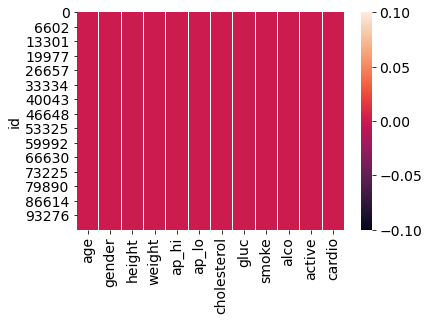

In [12]:
sns.heatmap(train.isnull())

# 2. EDA и очистка данных

Делаем EDA для:

* Исправления выбросов
* Заполнения NaN
* Идей для генерации новых фич

### 1. Обзор целевой переменной

In [13]:
train['cardio'].value_counts()  # Количество различных значений признака 'Credit Default'

0    35021
1    34979
Name: cardio, dtype: int64

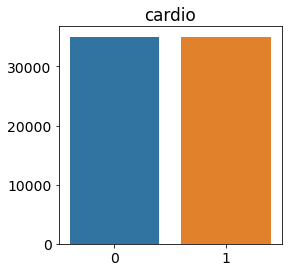

In [14]:
counts = train['cardio'].value_counts()
    
plt.figure(figsize=(4,4))    
plt.title('cardio')
sns.barplot(counts.index, counts.values)
    
plt.show()

## Приведение типов

In [15]:
# for colname in ['gender', 'smoke', 'alco', 'active', 'cholesterol', 'gluc']:
#      train[colname] = train[colname].astype(str)

In [16]:
train.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## Обзор количественных признаков

In [17]:
train.describe().T  # Анализ количественные признаки

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


### Выбросы

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'ap_hi'}>,
        <AxesSubplot:title={'center':'ap_lo'}>],
       [<AxesSubplot:title={'center':'cholesterol'}>,
        <AxesSubplot:title={'center':'gluc'}>,
        <AxesSubplot:title={'center':'smoke'}>],
       [<AxesSubplot:title={'center':'alco'}>,
        <AxesSubplot:title={'center':'active'}>,
        <AxesSubplot:title={'center':'cardio'}>]], dtype=object)

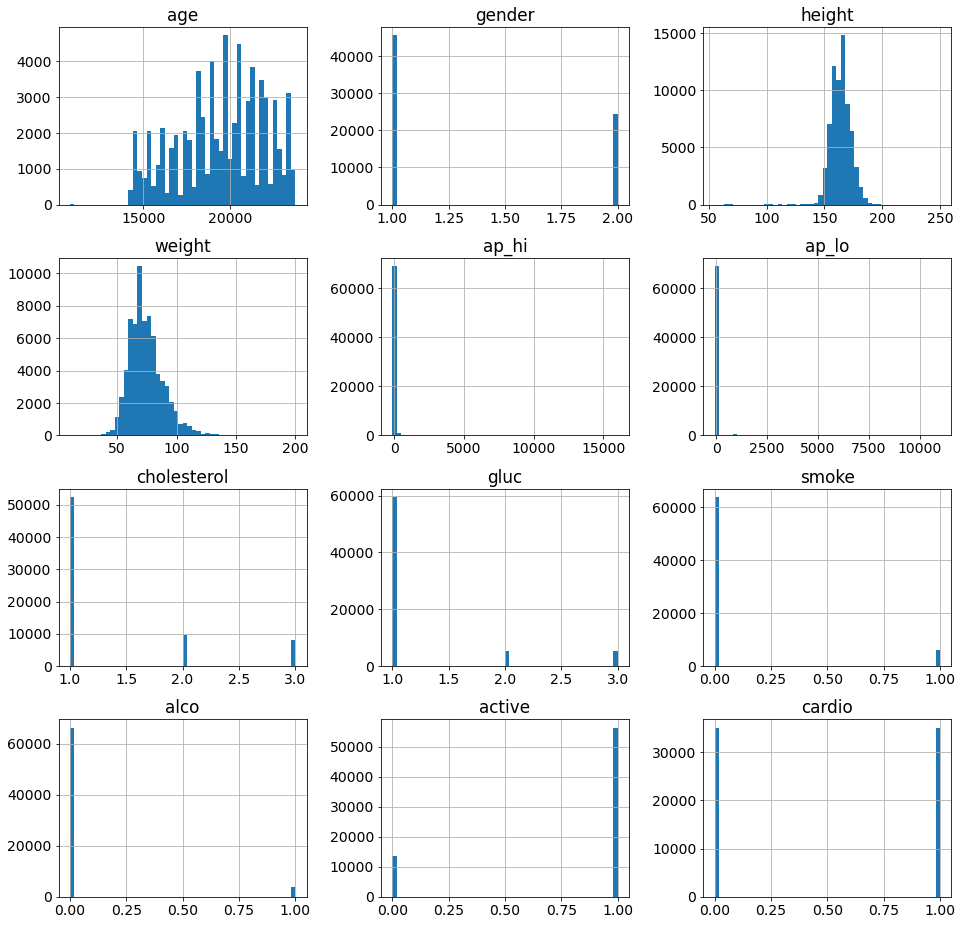

In [18]:
train_num_features = train.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])

train_num_features.hist(figsize=(16, 16), bins=50, grid=True)

Наблюдаются выбросы по следующим признакам: age, height, weight, ap_hi, ap_lo.

Ряд признаков имеют аномально высокое значение, но вполне вероятное: . Их необходимо будет ограничить.

## Приведение типов

In [19]:
for colname in ['gender', 'smoke', 'alco', 'active', 'cholesterol', 'gluc']:
     train[colname] = train[colname].astype(str)

In [20]:
train.dtypes

age              int64
gender          object
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio           int64
dtype: object

- Рассмотрим признаки подробнее

__1. age__ - Возраст (дни)

feature_name = age
feature_value_max = 24000
feature_value_min = 14000
__________________________________________________

Количество
__________________________________________________
14329     1
20701     1
21488     1
21509     1
16522     1
         ..
18253    31
20442    31
20376    31
18236    32
19741    32
Name: age, Length: 8076, dtype: int64
__________________________________________________

Отсортированные записи
__________________________________________________
id
31922    10798
43842    10859
8850     10878
79749    10964
45362    14275
         ...  
52297    23687
29892    23690
72373    23692
97124    23701
81643    23713
Name: age, Length: 70000, dtype: int64
__________________________________________________

Первичный датасет

Мода датасета: 18236
Медиана датасета: 19703.0
Среднее значение датасета: 19468.865814285713
Максимальное значение датасета: 23713
Минимальное значение датасета: 10798
__________________________________________________

Количество записей в 

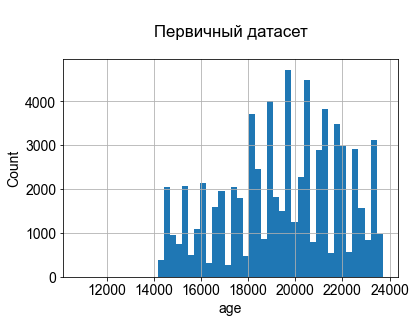

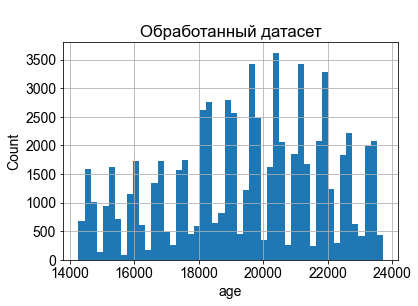

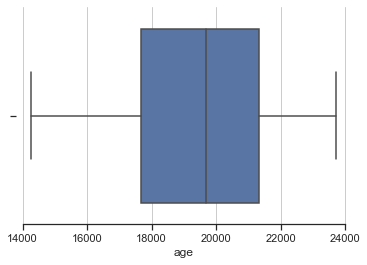

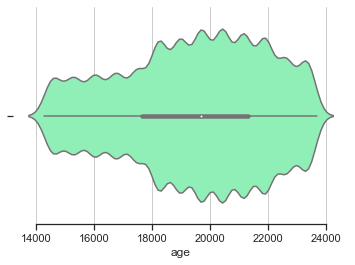

In [22]:
feature_name = 'age'
feature_value_max = 24000
feature_value_min = 14000
data_type = 0
plot_feature(feature_name, train, feature_value_max, feature_value_min, data_type)

# Считаем выбросами age > 24000 (0 значения) и age < 14000 (4 значения)

 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  

feature_name = height
feature_value_max = 190
feature_value_min = 130
__________________________________________________

Количество
__________________________________________________
64        1
66        1
128       1
71        1
72        1
       ... 
164    3396
168    4399
170    4679
160    5022
165    5853
Name: height, Length: 109, dtype: int64
__________________________________________________

Отсортированные записи
__________________________________________________
id
32456     55
95141     57
91523     59
41661     60
39462     64
        ... 
57307    198
12687    198
59847    200
30894    207
9223     250
Name: height, Length: 70000, dtype: int64
__________________________________________________

Первичный датасет

Мода датасета: 165
Медиана датасета: 165.0
Среднее значение датасета: 164.35922857142856
Максимальное значение датасета: 250
Минимальное значение датасета: 55
__________________________________________________

Количество записей в датасете: 70000
Количество 

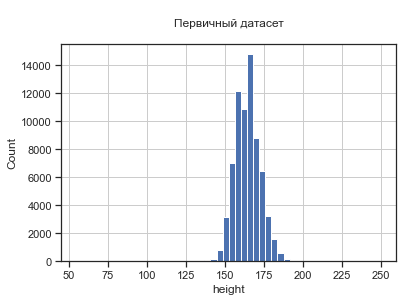

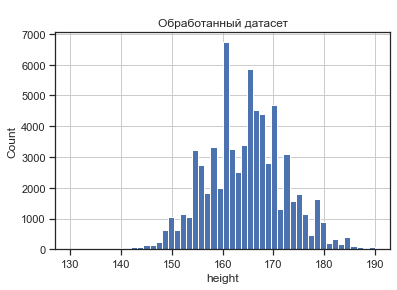

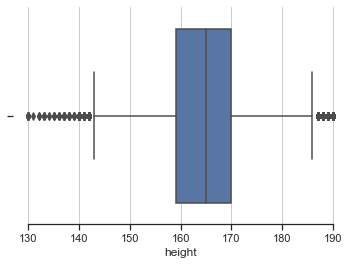

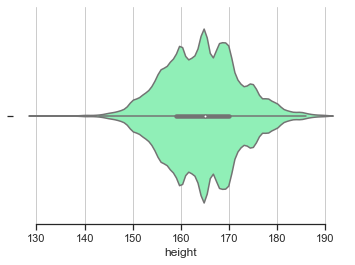

In [23]:
feature_name = 'height'
feature_value_max = 190
feature_value_min = 130
data_type = 0
plot_feature(feature_name, train, feature_value_max, feature_value_min, data_type)

# Количество записей в датасете: 70000
# Считаем выбросами height > 190 (64 значения) и height < 140 (152 значения)
# Считаем выбросами height > 195 (27 значения) и height < 130 (92 значения)
# Считаем выбросами height > 200 (2 значения) и height < 120 (52 значения)

feature_name = weight
feature_value_max = 200
feature_value_min = 30
__________________________________________________

Количество
__________________________________________________
50.7        1
53.2        1
163.0       1
105.5       1
55.6        1
         ... 
60.0     2710
75.0     2740
68.0     2831
70.0     3764
65.0     3850
Name: weight, Length: 287, dtype: int64
__________________________________________________

Отсортированные записи
__________________________________________________
id
82567     10.0
48318     11.0
85931     21.0
42156     22.0
38312     23.0
         ...  
87612    180.0
52564    181.0
87498    183.0
71945    200.0
618      200.0
Name: weight, Length: 70000, dtype: float64
__________________________________________________

Первичный датасет

Мода датасета: 65.0
Медиана датасета: 72.0
Среднее значение датасета: 74.20569
Максимальное значение датасета: 200.0
Минимальное значение датасета: 10.0
__________________________________________________

Количеств

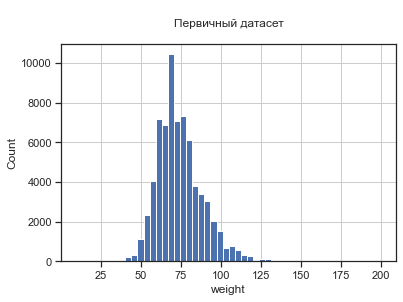

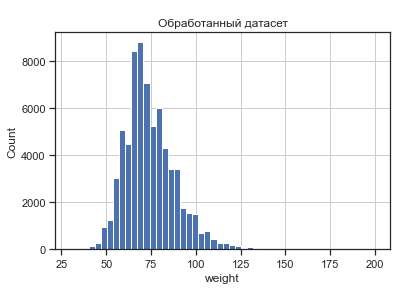

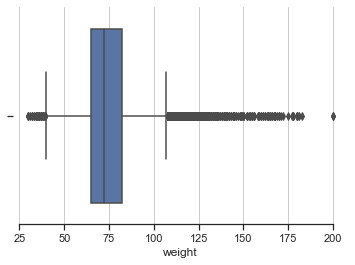

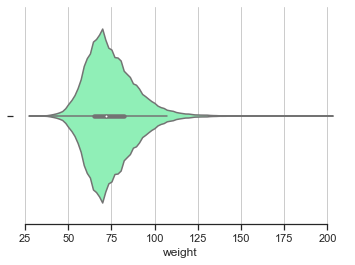

In [24]:
feature_name = 'weight'
feature_value_max = 200
feature_value_min = 30
data_type = 0
plot_feature(feature_name, train, feature_value_max, feature_value_min, data_type)

# Количество записей в датасете: 70000
# Считаем выбросами weight > 30 (7 значения) и weight < 200 (0 значения)


# Количество записей в датасете < 40: 52
# Количество записей в датасете < 30: 7
# Количество записей в датасете < 25: 5
# Количество записей в датасете < 20: 2
# Количество записей в датасете < 15: 2
# Количество записей в датасете < 10: 0

# Количество записей в датасете > 200: 0
# Количество записей в датасете > 190: 2
# Количество записей в датасете > 180: 4
# Количество записей в датасете > 170: 15
# Количество записей в датасете > 160: 40
# Количество записей в датасете > 150: 59
# Количество записей в датасете > 140: 98
# Количество записей в датасете > 130: 202

feature_name = ap_hi
feature_value_max = 200
feature_value_min = 60
__________________________________________________

Количество
__________________________________________________
93          1
60          1
187         1
1409        1
184         1
        ...  
150      4450
110      8644
130      8961
140      9506
120     27699
Name: ap_hi, Length: 153, dtype: int64
__________________________________________________

Отсортированные записи
__________________________________________________
id
50055     -150
34295     -140
66571     -120
36025     -120
22881     -115
         ...  
67502    14020
36339    14020
36414    14020
66998    14020
58374    16020
Name: ap_hi, Length: 70000, dtype: int64
__________________________________________________

Первичный датасет

Мода датасета: 120
Медиана датасета: 120.0
Среднее значение датасета: 128.8172857142857
Максимальное значение датасета: 16020
Минимальное значение датасета: -150
__________________________________________________

Колич

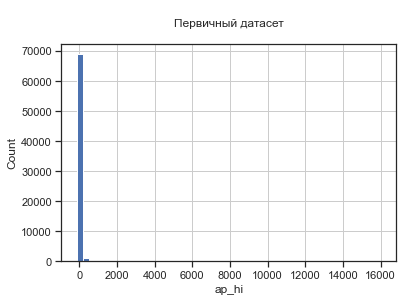

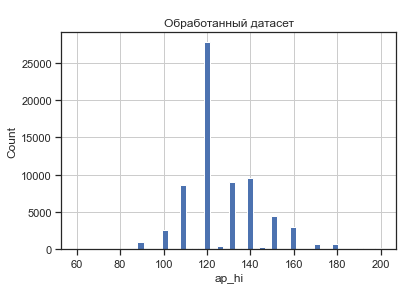

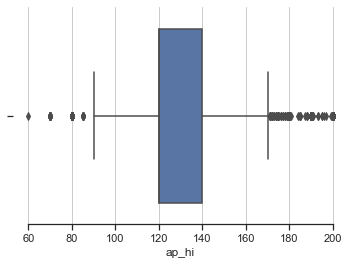

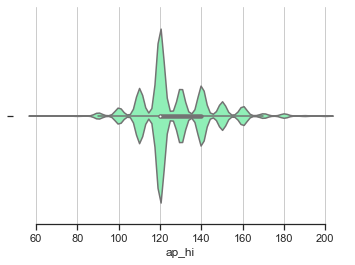

In [25]:
#ap_hi
#ap_lo 

feature_name = 'ap_hi'
feature_value_max = 200
feature_value_min = 60
data_type = 0
plot_feature(feature_name, train, feature_value_max, feature_value_min, data_type)

# Количество записей в датасете: 70000
# Считаем выбросами ap_hi > 200 (100 значения) и ap_hi < 60 (188 значения)

# Количество записей в датасете: 70000
# Количество записей в датасете < -1000: 0
# Количество записей в датасете < -100: 5
# Количество записей в датасете < -10: 7
# Количество записей в датасете < 0: 7
# Количество записей в датасете < 30: 188
# Количество записей в датасете < 50: 188
# Количество записей в датасете < 60: 188
# Количество записей в датасете < 65: 189
# Количество записей в датасете < 70: 189
# Количество записей в датасете < 80: 207
# Количество записей в датасете < 85: 311

# Количество записей в датасете > 3000: 9
# Количество записей в датасете > 2000: 9
# Количество записей в датасете > 1000: 24
# Количество записей в датасете > 500: 38
# Количество записей в датасете > 200: 100


feature_name = ap_lo
feature_value_max = 200
feature_value_min = 40
__________________________________________________

Количество
__________________________________________________
7100        1
8044        1
810         1
1002        1
107         1
        ...  
60       2727
100      4082
70      10245
90      14316
80      34847
Name: ap_lo, Length: 157, dtype: int64
__________________________________________________

Отсортированные записи
__________________________________________________
id
85816      -70
57646        0
60565        0
81298        0
91073        0
         ...  
62058     9800
97907    10000
34098    10000
3352     10000
61901    11000
Name: ap_lo, Length: 70000, dtype: int64
__________________________________________________

Первичный датасет

Мода датасета: 80
Медиана датасета: 80.0
Среднее значение датасета: 96.63041428571428
Максимальное значение датасета: 11000
Минимальное значение датасета: -70
__________________________________________________

Количест

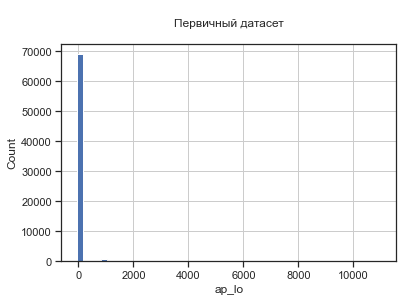

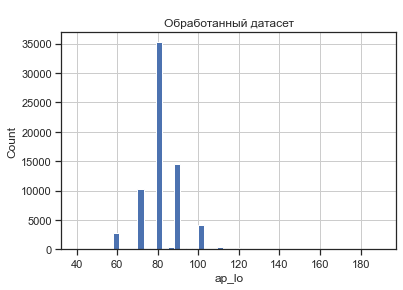

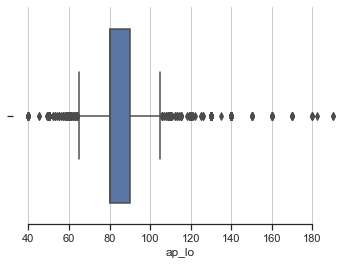

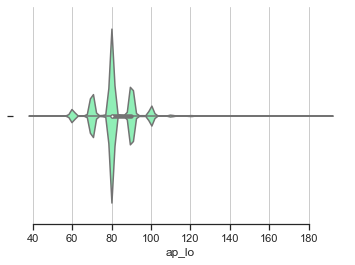

In [26]:
feature_name = 'ap_lo'
feature_value_max = 200
feature_value_min = 40
data_type = 0
plot_feature(feature_name, train, feature_value_max, feature_value_min, data_type)

# Количество записей в датасете: 70000
# Считаем выбросами ap_lo > 200 (953 значения) и ap_lo < 30 (53 значения)


# Количество записей в датасете < 0: 1
# Количество записей в датасете < 10: 30
# Количество записей в датасете < 20: 38
# Количество записей в датасете < 30: 53
# Количество записей в датасете < 40: 59
# Количество записей в датасете < 50: 80
# Количество записей в датасете < 60: 175
# Количество записей в датасете < 70: 3154
# Количество записей в датасете < 80: 14116

# Количество записей в датасете > 200: 953
# Количество записей в датасете > 300: 953
# Количество записей в датасете > 400: 953
# Количество записей в датасете > 500: 953
# Количество записей в датасете > 600: 952
# Количество записей в датасете > 700: 950
# Количество записей в датасете > 800: 939
# Количество записей в датасете > 900: 925
# Количество записей в датасете > 1000: 255

__Обзор значений категориальных признаков__

In [27]:
train.select_dtypes(include='object').columns

Index(['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'], dtype='object')

In [28]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

gender

1    45530
2    24470
Name: gender, dtype: int64
****************************************************************************************************

cholesterol

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64
****************************************************************************************************

gluc

1    59479
3     5331
2     5190
Name: gluc, dtype: int64
****************************************************************************************************

smoke

0    63831
1     6169
Name: smoke, dtype: int64
****************************************************************************************************

alco

0    66236
1     3764
Name: alco, dtype: int64
****************************************************************************************************

active

1    56261
0    13739
Name: active, dtype: int64
****************************************************************************************************



### 2. Обработка выбросов<a class="anchor" id="outliers"></a>

1. **age** - взраст в днях
* выбросов нет
* **Считаем выбросами age > 24 000 (0 значения) и age < 14 000 (4 значения)**

2. **height** - рост
* **Считаем выбросами height > 190 (64 значения) и height < 140 (152 значения)**

3. **weight** - вес
* **Считаем выбросами weight > 30 (7 значения) и weight < 200 (0 значения)**

4. **ap_hi** - артериальное давление (верхнее)
* **Считаем выбросами ap_hi > 200 (100 значения) и ap_hi < 60 (188 значения)**

5. **ap_hi** - артериальное давление (нижнее)
* **Считаем выбросами ap_lo > 200 (953 значения) и ap_lo < 30 (53 значения)**


### 3. Обработка пропусков<a class="anchor" id="gaps"></a>

In [29]:
train.isnull()
# train.notnull()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,False,False,False,False,False,False,False,False,False,False,False,False
99995,False,False,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,False,False


In [30]:
# len(train) - train.count()

In [31]:
train.isna().sum()  # просматриваем пропуски

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

__Пропусков нет__

In [32]:
train.info()  # Рассмотрим типы признаков

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  object 
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  object 
 7   gluc         70000 non-null  object 
 8   smoke        70000 non-null  object 
 9   alco         70000 non-null  object 
 10  active       70000 non-null  object 
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 6.9+ MB


### Класс с подготовкой данных

In [33]:
class DataPipeLine:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса:
           Константы для обработки выбрасов"""
        
        self.medians = None
        self.modes = None
       
        self.age_min = 14000
        self.age_max = 24000
       
        self.height_min = 100
        self.height_max = 220

        self.weight_min = 50
        self.weight_max = 200
    
        self.ap_hi_min = -100
        self.ap_hi_max = 200
        
        self.ap_lo_min = 0
        self.ap_lo_max = 200
        

    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчёт медиан
        # self.medians = df_train[['Annual Income', 'Credit Score']].median()
        # df = df_train.loc[df_train['Current Loan Amount'] < self.CurrentLoanAmount_max, ['Current Loan Amount']]
        # self.modes = df[['Current Loan Amount']].median()

    def transform(self, df):
        """Трансформация данных"""
        
        # 2. Выбросы (outliers)        

        # age - возраст в днях
        # Считаем выбросами age > 24 000 (0 значения) и age < 14 000 (4 значения)
        df.loc[df['age'] < self.age_min, 'age'] = self.age_min
        df.loc[df['age'] >= self.age_max, 'age'] = self.age_max
        
        # height - рост
        # Считаем выбросами height > 190 (64 значения) и height < 140 (152 значения)
        df.loc[df['height'] < self.height_min, 'height'] = self.height_min
        df.loc[df['height'] >= self.height_max, 'height'] = self.height_max
        
        # weight - вес
        # Считаем выбросами weight > 30 (7 значения) и weight < 200 (0 значения)
        df.loc[df['weight'] < self.weight_min, 'weight'] = self.weight_min
        df.loc[df['weight'] >= self.weight_max, 'weight'] = self.weight_max
        
        # ap_hi - артериальное давление (верхнее)
        # Считаем выбросами ap_hi > 200 (100 значения) и ap_hi < 60 (188 значения)
        df.loc[df['ap_hi'] < self.ap_hi_min, 'ap_hi'] = self.ap_hi_min
        df.loc[df['ap_hi'] >= self.ap_hi_max, 'ap_hi'] = self.ap_hi_max
        
        # ap_hi - артериальное давление (нижнее)
        # Считаем выбросами ap_lo > 200 (953 значения) и ap_lo < 30 (53 значения)
        df.loc[df['ap_lo'] < self.ap_lo_min, 'ap_lo'] = self.ap_lo_min
        df.loc[df['ap_lo'] >= self.ap_lo_max, 'ap_lo'] = self.ap_lo_max
        
        # 3. Обработка категорий
        # colname = 'Bankruptcies'
        # df[colname] = df[colname].replace(to_replace = 'nan', value = '0.0')
        
        return df

### Инициализируем класс

In [34]:
data_pl = DataPipeLine()

# тренировочные данные
data_pl.fit(train)

df = data_pl.transform(train)

In [35]:
df.info()  # Рассмотрим типы признаков

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  object 
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  object 
 7   gluc         70000 non-null  object 
 8   smoke        70000 non-null  object 
 9   alco         70000 non-null  object 
 10  active       70000 non-null  object 
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 6.9+ MB


In [36]:
for cat_colname in df.select_dtypes(include='int64').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

age

18236    32
19741    32
18253    31
20442    31
20376    31
         ..
19393     1
19427     1
23713     1
15597     1
14329     1
Name: age, Length: 8073, dtype: int64
****************************************************************************************************

height

165    5853
160    5022
170    4679
168    4399
164    3396
       ... 
112       1
111       1
207       1
108       1
128       1
Name: height, Length: 87, dtype: int64
****************************************************************************************************

ap_hi

120    27699
140     9506
130     8961
110     8644
150     4450
       ...  
93         1
199        1
184        1
24         1
197        1
Name: ap_hi, Length: 117, dtype: int64
****************************************************************************************************

ap_lo

80     34847
90     14316
70     10245
100     4082
60      2727
       ...  
56         1
114        1
1          1
54         1
118        1
N

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  object 
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  object 
 7   gluc         70000 non-null  object 
 8   smoke        70000 non-null  object 
 9   alco         70000 non-null  object 
 10  active       70000 non-null  object 
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 6.9+ MB


In [38]:
df.describe().T  # Анализ количественныхпризнаки

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19469.044400,2466.742604,14000.0,17664.0,19703.0,21327.0,23713.0
height,70000.0,164.369900,8.096824,100.0,159.0,165.0,170.0,220.0
weight,70000.0,74.271941,14.264975,50.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,126.709786,18.185728,-100.0,120.0,120.0,140.0,200.0
ap_lo,70000.0,82.939614,16.912714,0.0,80.0,80.0,90.0,200.0
cardio,70000.0,0.499700,0.500003,0.0,0.0,0.0,1.0,1.0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'ap_hi'}>],
       [<AxesSubplot:title={'center':'ap_lo'}>, <AxesSubplot:>]],
      dtype=object)

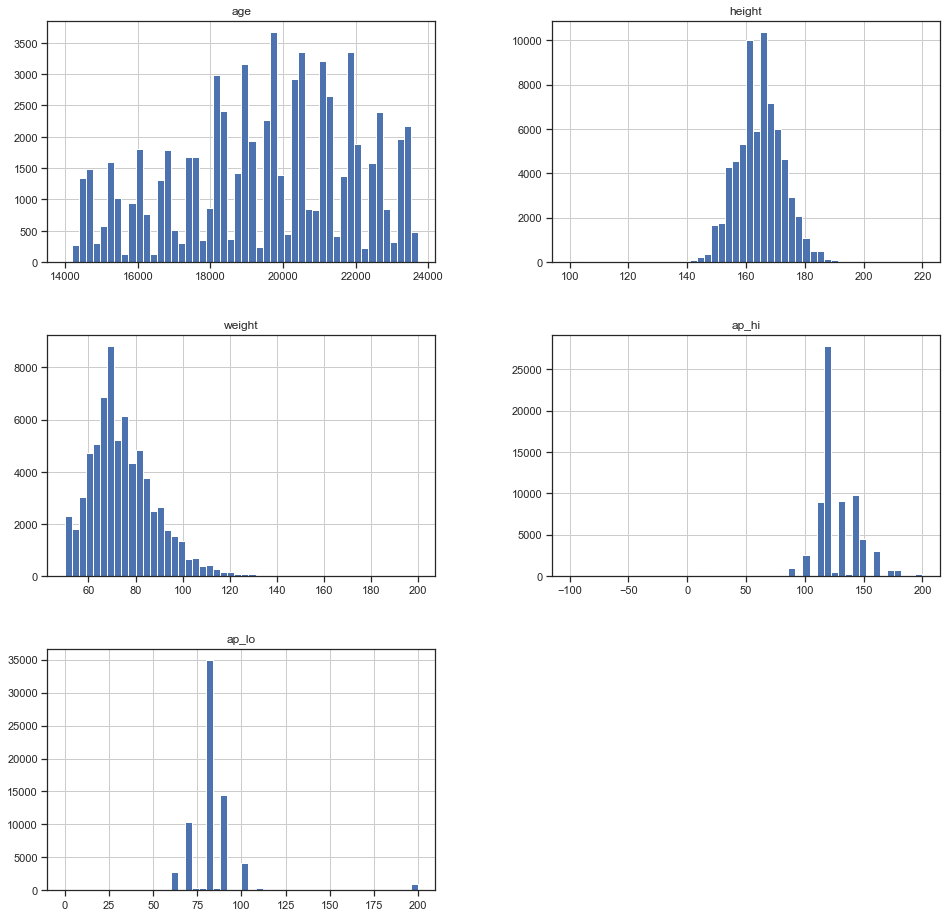

In [39]:
colomns = ['age', 'gender', 'height', 'weight', 'ap_hi',
               'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

train_num_features = train[colomns].select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])

train_num_features.hist(figsize=(16, 16), bins=50, grid=True)

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  object 
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  object 
 7   gluc         70000 non-null  object 
 8   smoke        70000 non-null  object 
 9   alco         70000 non-null  object 
 10  active       70000 non-null  object 
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 6.9+ MB


## 7. Подбор моделей, получение бейзлана<a class="anchor" id="model_matching"></a>

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score#, precision_score, recall_score

from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.neighbors import KNeighborsClassifier  # k ближайших соседей
from sklearn.tree import DecisionTreeClassifier  # Дерево решений
import xgboost as xgb 
import lightgbm as lgbm
import catboost as catb

Разделим наши данные на тренировочную и тестовую выборки

In [42]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

#разделим данные на train/test
# X_train, X_test, y_train, y_test = train_test_split(train.drop('cardio', 1), 
#                                                     train['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

import itertools

In [44]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [45]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.7343500647659122, 0.6952286975463144, 0.7506184056212063, ...,
        '1', '0', '1'],
       [-1.673855180301589, 0.07740558656716892, -0.30346246819696143,
        ..., '0', '0', '1'],
       [0.1373373002040867, 1.189487186329631, -0.16291835168787241, ...,
        '0', '0', '0'],
       ...,
       [1.1779305141776457, 1.189487186329631, -0.16291835168787241, ...,
        '0', '0', '1'],
       [-0.47207760973516893, -1.4053698797827805, 0.7506184056212063,
        ..., '0', '0', '1'],
       [0.3817528736773924, 0.5716640753504854, -0.09264629343332789,
        ..., '0', '0', '1']], dtype=object)

# 
## 1 Задание

обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

__2 Задание__<br>
при обучении моделей обязательно использовать кроссвалидацию

__2 задание__ реализуем в рамках __задания 1__

### 1.1 Логистическая регрессия

Добавим классификатор и запустим кросс-валидацию

In [46]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

__2 Задание__<br>
при обучении моделей обязательно использовать кроссвалидацию

In [47]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7906856219971305+-0.007739605182611138


In [48]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

#### Рассчитаем Precision/Recall/F_score (для них - подберём оптимальный порог с помощью precision_recall_curve)

In [49]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.383136, F-Score=0.732, Precision=0.658, Recall=0.826


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

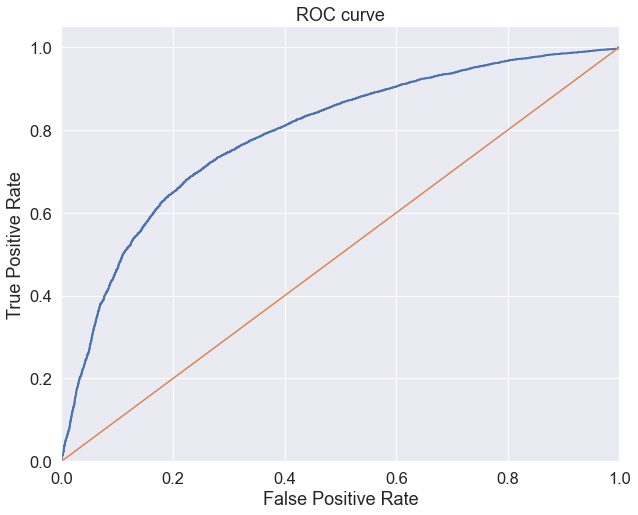

In [50]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

#### Рассчитаем ROC AUC и log loss

In [51]:
from sklearn.metrics import roc_auc_score, log_loss
auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7886055270802638
log loss score: 0.569373250318223


Сохраним метрики для дальнейшей анализа (см. задания 3)

In [52]:
metrics = []
metric = {}
metric = {'Model': 'LogisticRegression',
          'AUC&ROC': auc,
          'log loss':logloss,
          'F-Score': fscore[ix],
          'Precision': precision[ix],
          'Recall': recall[ix],
          'Best Threshold': thresholds[ix]
         }

metrics.append(metric)
metrics

[{'Model': 'LogisticRegression',
  'AUC&ROC': 0.7886055270802638,
  'log loss': 0.569373250318223,
  'F-Score': 0.7323080067446732,
  'Precision': 0.6579744743366082,
  'Recall': 0.8255760368663595,
  'Best Threshold': 0.38313640417800293}]

### Построим матрицу ошибок

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[5095 3725]
 [1515 7165]]


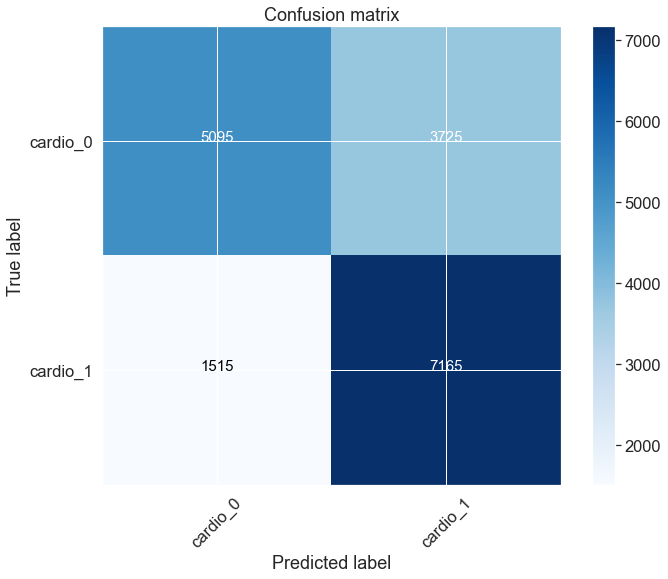

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [55]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(f'{TP}(TP) {FP}(FP)\n{FN}(FN) {TN}(TN)')

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
#TPR, FPR, TNR
print(f'TPR = {TPR}, FPR = {FPR}(FP), TNR = {TNR}')

7165(TP) 3725(FP)
1515(FN) 5095(TN)
TPR = 0.8254608294930875, FPR = 0.4223356009070295(FP), TNR = 0.5776643990929705


__С преобработкой данных__<br>
7165 (TP) 3725 (FP)<br>
1515 (FN) 5095 (TN)<br>

TPR = 0.8254608294930875, FPR = 0.4223356009070295(FP), TNR = 0.5776643990929705<br>

age_min = 14000<br>
age_max = 24000<br>
       
height_min = 100<br>
height_max = 220<br>

weight_min = 50<br>
weight_max = 200<br>
    
ap_hi_min = -100<br>
ap_hi_max = 200<br>
        
ap_lo_min = 0<br>
ap_lo_max = 200<br>

__без обработки__<br>
7269 (TP) 3959 (FP)<br>
1441 (FN) 4851 (TN)<br>

TPR = 0.837442396313364, FPR = 0.44886621315192743, TNR = 0.5511337868480726 


### 1.2 Случайный лес

In [56]:
from sklearn.ensemble import RandomForestClassifier

Добавим классификатор и запустим кросс-валидацию

In [57]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state=21,
                                    class_weight={0:1, 1:3.6},
                                    max_depth=100
                                    ))
])

__2 Задание__<br>
при обучении моделей обязательно использовать кроссвалидацию

In [58]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7732524699515626+-0.007953309567838112


In [59]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

#### Рассчитаем Precision/Recall/F_score (для них - подберём оптимальный порог с помощью precision_recall_curve)

In [60]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.337826, F-Score=0.719, Precision=0.643, Recall=0.814


#### Рассчитаем ROC AUC и log loss

In [61]:
from sklearn.metrics import roc_auc_score, log_loss
auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7699635372582213
log loss score: 0.6060100614543436


Сохраним метрики для дальнейшей анализа (см. задания 3)

In [62]:
metric = {}
metric = {'Model': 'RandomForest',  # Случайный лес
          'AUC&ROC': auc,
          'log loss':logloss,
          'F-Score': fscore[ix],
          'Precision': precision[ix],
          'Recall': recall[ix],
          'Best Threshold': thresholds[ix]
         }

metrics.append(metric)

In [63]:
metrics[1]

{'Model': 'RandomForest',
 'AUC&ROC': 0.7699635372582213,
 'log loss': 0.6060100614543436,
 'F-Score': 0.7186244086076208,
 'Precision': 0.6434362758495035,
 'Recall': 0.8137096774193548,
 'Best Threshold': 0.3378260869565217}

### 1.3 Бустинговые алгоритмы

*XGBoost*

In [64]:
import xgboost as xgb 

In [65]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state=21,
#                               n_estimators=100
                             ))
])

__2 Задание__<br>
при обучении моделей обязательно использовать кроссвалидацию

In [66]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

[15:27:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [67]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

[15:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Рассчитаем Precision/Recall/F_score

In [68]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.348672, F-Score=0.736, Precision=0.665, Recall=0.824


#### Рассчитаем ROC AUC и log loss

In [69]:
from sklearn.metrics import roc_auc_score, log_loss
auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7955620147444539
log loss score: 0.5496474384521799


Сохраним метрики для дальнейшей анализа (см. задания 3)

In [70]:
metric = {}
metric = {'Model': 'xgboost',  # Случайный лес
          'AUC&ROC': auc,
          'log loss':logloss,
          'F-Score': fscore[ix],
          'Precision': precision[ix],
          'Recall': recall[ix],
          'Best Threshold': thresholds[ix]
         }

metrics.append(metric)
metrics[2]

{'Model': 'xgboost',
 'AUC&ROC': 0.7955620147444539,
 'log loss': 0.5496474384521799,
 'F-Score': 0.7363491328289846,
 'Precision': 0.665426471956097,
 'Recall': 0.8241935483870968,
 'Best Threshold': 0.34867162}

# 
## 3. Задача:

вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [71]:
import pandas as pd
  
df = pd.DataFrame(metrics).sort_index().sort_values('Recall', kind='mergesort')

In [72]:
# df.set_index('embedding_method', inplace=True)
df.sort_values('F-Score')

,Model,AUC&ROC,log loss,F-Score,Precision,Recall,Best Threshold
1,RandomForest,0.769964,0.606010,0.718624,0.643436,0.813710,0.337826
0,LogisticRegression,0.788606,0.569373,0.732308,0.657974,0.825576,0.383136
2,xgboost,0.795562,0.549647,0.736349,0.665426,0.824194,0.348672


# 
## 4. Задача:

сделать выводы о том, какая модель справилась с задачей лучше других

Модели показали следующие результаты

__RandomForest__ (Случайный лес):

- AUC&ROC = 0.769964
- logloss =	0.606010
- F-Score = 0.718624
- Precision = 0.643436
- Recall = 0.813710

__LogisticRegression__ (Логистическая регрессия):

- AUC&ROC = 0.788606
- logloss =	0.569373
- F-Score = 0.732308
- Precision = 0.657974
- Recall = 0.825576

__xgboost__ (XGBoost):

- AUC&ROC = 0.795562
- logloss =	0.549647
- F-Score = 0.736349
- Precision = 0.665426
- Recall = 0.824194

__Вывод__

Видно, что лучший результат из всех показала бустинговая модель __XGBoost__. <br>
Она имеет максимальные занчения метрик среди всех моделей.<br>

Таким образом, в нашем конкретном случае, модель __XGBoost__ лучше остальных моделей справилась с нашей задачей классификации.


# 
## 5. Задача:

(опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

__Кривая ROC__

Это график зависимости числа ложных срабатываний (ось X) от истинного положительного значения (ось Y) для ряда различных возможных пороговых значений от 0,0 до 1,0. Иными словами, он отображает частоту ложных срабатываний и частоту попаданий.

__Кривая «полнота-точность»__

Эта кривая строится в координатах полнота (R = recall, ось x) и точность (P = precision, ось y). Площадь под ней часто используют в качестве метрики качества алгоритма. 



Площадь под PR-кривой (AUC_PR) рекомендуют использовать как раз в задачах с дисбалансом классов, аргументируя это тем, что эта кривая точнее описывает правильность классификации объектов с большими оценками, тогда как ROC-кривая — различие распределений объектов разных классов по оценкам.

Отдельно обращаем внимание, что при изменении баланса классов значение AUC_PR меняется.

Кривые в машинном обучении - https://dyakonov.org/2019/08/29/кривые-в-машинном-обучении/<br>
How to Use ROC Curves and Precision-Recall Curves for Classification in Python - https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

__Ответ__

Кривые ROC подходят, когда наблюдения сбалансированы между каждым классом, тогда как кривые AUC подходят для несбалансированных наборов данных.

## 
## Приложение

![ab_split](..\lection3_materials\pr_rec.png "PRRecall")

#### F-score — среднее гармоническое precision и recall 

![ab_split](..\lection3_materials\f_score1.png "F-score")

#### ROC AUC

![ab_split](..\lection3_materials\tpr_fpr.png "roc auc1")